## Task 2: Dataset Visualization with FiftyOne

In this notebook, we explore the dataset required for Assessment 2, synthetically generated using NVIDIA Omniverse as a “hello world” benchmark for multimodal machine learning. The dataset consists of simple geometric objects—cubes and spheres—captured using two different sensing modalities: RGB images and 2D LiDAR projections.

The objective of this notebook is to inspect and validate the multimodal data prior to model development in notebooks `02_*`, `03_*`, and `04_*`. To this end, we construct a FiftyOne dataset from the RGB and LiDAR images located in the `cubes/` and `spheres/` directories under `/data/assessment/`. Since LiDAR data are acquired from a different viewpoint than RGB images, we first align the modalities as closely as possible by converting LiDAR beam angles into Cartesian coordinates and grouping corresponding RGB–LiDAR pairs using FiftyOne’s `group` field.

To ensure reproducibility, we then create fixed training and validation splits using `30%` of the original dataset. The selected sample identifiers and metadata are stored in a `.json` file, which is later reused in subsequent notebooks via a custom dataset class to guarantee identical data partitions. This dataloader returns paired RGB and LiDAR inputs, including an additional alpha channel.

Finally, we compute basic dataset statistics - such as label distributions across splits - and launch the FiftyOne App to visually inspect the aligned multimodal samples and verify the integrity of the generated splits.

As a first step, ensure that FiftyOne version 1.11.0 is correctly installed in your environment. Other versions may cause some built-in FiftyOne functions to malfunction. If necessary, please reinstall the correct version in this notebook by uncommenting the cell below.

In [1]:
# !pip install fiftyone==1.11.0

In [2]:
%load_ext autoreload
%autoreload 2

import random
import json
import numpy as np
import fiftyone.utils.random as four
import fiftyone.core.expressions as fe
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image

from handsoncv.datasets import create_lidar_viz
from handsoncv.utils import set_seed, seed_worker
from handsoncv.visualization import plot_class_distribution

import os
# Set FiftyOne App to work in Remote SSH
os.environ["FIFTYONE_DISABLE_NOTEBOOK_APP"] = "1"

import fiftyone as fo
fo.app_config.enable_notebook_app = True

# Configuration Folders 
NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "..", ".."))

# Folders we frequently to load the data in this notebook and across the experiments' notebooks
ROOT_PATH = os.path.join(PROJECT_ROOT, "Assignment-2")
RESULTS_DIR = os.path.join(ROOT_PATH, "results", "fiftyone_figures_screenshots")
os.makedirs(RESULTS_DIR, exist_ok=True) # Ensures folder exists 

CHECKPOINTS_DIR = os.path.join(ROOT_PATH, "checkpoints")
ROOT_DATA = "~/Documents/repos/BuildingAIAgentsWithMultimodalModels/data/assessment/"
# PATH = "~/Documents/repos/Applied-Hands-On-Computer-Vision/Assignment-2/data/" #"~/mnt/gdrive/path/to/your/assessment_folder" # Update this path to where the data is

We begin by defining a dataset name to be passed to FiftyOne’s `list_datasets()` interface. This ensures that the dataset can be uniquely identified, reused, and safely reloaded across sessions without duplication, which is essential for iterative visual inspection and debugging.

Next, we specify a directory for storing the transformed LiDAR samples. In this step, the original LiDAR data are converted into aligned XYZA coordinate representations, enabling consistent spatial correspondence with the RGB modality and facilitating grouped visualization within FiftyOne.

For reproducibility, we fix a deterministic random seed using a utility function that synchronizes randomness across NumPy, PyTorch, CUDA, and enforces deterministic behavior in the cuDNN backend. This guarantees consistent data shuffling, subset selection, and training behavior across runs.

Finally, we define the percentage of data to be retained when constructing a subset. After iterating through the dataset to create grouped RGB–LiDAR samples in FiftyOne, a reproducible subset is selected and its metadata - including unique sample identifiers (`<label>_<img-id>`), split assignments, subset percentile, and the seed used - is serialized to a `.json` file. This file serves as a persistent reference for reconstructing identical training and validation splits - via a custom data-loading function implemented in `src/datasets.py` -, which constructs the training and validation splits from predefined sample lists in notebooks `02_*`, `03_*` and `04_*`.


In [3]:
# Define Fiftyone's dataset name for list_dataset() interface
fiftyone_dataset_name = "cilp_assessment"

# Define and create a directory for storing the transformed XYZA LiDAR samples, which are used exclusively for visualization within the FiftyOne interface in this notebook
PROCESSED_DIR = Path(os.path.join(os.path.expanduser(ROOT_DATA), "processed_viz"))
PROCESSED_DIR.mkdir(exist_ok=True)

# Set reproducibility
SEED = 42
set_seed(SEED)

#Set the percentage of data to retain for quicker experimentation in this notebook and subsequent ones
PERCENTAGE_SUBSET = 0.3 

Seeds set to 42 for reproducibility.


###  Requirement 2.1 (Grouped Dataset)

In this subsection, we construct a grouped FiftyOne dataset that jointly represents the RGB and LiDAR modalities for the cube and sphere classes. First, any existing dataset with the same name is removed to ensure a clean initialization. A new FiftyOne dataset is then created, and a `group` field is added to explicitly link samples belonging to the same physical scene across different modalities.

For each class (`cubes` and `spheres`), RGB images and corresponding LiDAR `.npy` files are matched by filename. The LiDAR data are converted into visual PNG representations (XYZA projections) solely for visualization purposes, while retaining references to the original `.npy` files for downstream processing.

Each RGB-LiDAR pair is organized as a grouped sample with the following properties:
- Samples are linked via a shared group identifier.
- Each sample is annotated with a classification label (`cube` or `sphere`).
- File paths to both RGB images and LiDAR visualizations are stored, along with a reference to the raw LiDAR data.

Finally, `30%` of the grouped samples is selected using a fixed random seed, ready to be added to the dataset in the next subsection, and persisted for reuse across notebook sessions.

In [4]:
# ----------------------------
# Dataset cleanup and initialization
# ----------------------------
if fiftyone_dataset_name in fo.list_datasets():
    fo.delete_dataset(fiftyone_dataset_name)
    
dataset = fo.Dataset(fiftyone_dataset_name)
dataset.add_group_field("group", default="rgb")

# ----------------------------
# Build grouped RGB–LiDAR samples
# ----------------------------
classes = ["cubes", "spheres"]
all_pairs = []

for label in classes:
    class_dir = Path(os.path.expanduser(ROOT_DATA))/ label
    rgb_dir = class_dir / "rgb"
    lidar_dir = class_dir / "lidar"
    
    if not rgb_dir.exists():
        print(f"Skipping {label}: {rgb_dir} not found.")
        continue
    
    # Load shared angular metadata for LiDAR projection
    azimuth = np.load(class_dir / "azimuth.npy")
    zenith = np.load(class_dir / "zenith.npy")
    
    # Match RGB and LiDAR files by filename stem
    rgb_files = {f.stem: f for f in rgb_dir.glob("*") if f.suffix.lower() in [".png", ".jpg"]}
    lidar_files = {f.stem: f for f in lidar_dir.glob("*") if f.suffix.lower() == ".npy"}
    matching_stems = sorted(set(rgb_files.keys()) & set(lidar_files.keys()))
    print(f"Found {len(matching_stems)} pairs for class: {label}")
    
    for stem in tqdm(matching_stems, desc=f"Processing {label}"):
        # Generate and save LiDAR visualization for FiftyOne (if not already cached)
        viz_path = PROCESSED_DIR / f"{label}_{stem}_lidar_viz.png"
        if not viz_path.exists():
            create_lidar_viz(lidar_files[stem], azimuth, zenith, viz_path)
            
        group = fo.Group()
        
        # RGB sample
        rgb_sample = fo.Sample(filepath=str(rgb_files[stem]), group=group.element("rgb"))
        rgb_sample["ground_truth"] = fo.Classification(label=label.rstrip('s')) # Normalize to 'cube'/'sphere'
        
        # LiDAR sample (visualization + reference to raw data)
        lidar_sample = fo.Sample(filepath=str(viz_path), group=group.element("lidar"))
        lidar_sample["ground_truth"] = fo.Classification(label=label.rstrip('s'))
        lidar_sample["raw_npy_path"] = str(lidar_files[stem]) # Store reference to original data

        all_pairs.append((rgb_sample, lidar_sample))
    
# ----------------------------
# Subset selection and persistence
# ----------------------------
set_seed(SEED) 
random.shuffle(all_pairs)
subset_size = int(len(all_pairs) * PERCENTAGE_SUBSET)
subset = all_pairs[:subset_size]

dataset.add_samples([s for pair in subset for s in pair]) # Flatten pairs and add to dataset
dataset.persistent = True

print(f"\n✅ Created grouped dataset: {dataset.name}")
print(f"Group slices: {dataset.group_slices}")

Found 9999 pairs for class: cubes


Processing cubes: 100%|██████████| 9999/9999 [00:03<00:00, 2855.24it/s]


Found 9999 pairs for class: spheres


Processing spheres: 100%|██████████| 9999/9999 [00:03<00:00, 2860.60it/s]

Seeds set to 42 for reproducibility.
   0% ||------------|     1/11998 [21.1ms elapsed, 4.2m remaining, 47.3 samples/s] 

 100% |█████████████| 11998/11998 [5.5s elapsed, 0s remaining, 2.4K samples/s]      

✅ Created grouped dataset: cilp_assessment
Group slices: ['rgb', 'lidar']


### Requirement 2.2 (Dataset Statistics)

In this subsection, we compute and report descriptive statistics for the constructed multimodal dataset as an important preparatory step prior to model construction and training.

We first provide a global overview, including the total number of samples and the number of grouped RGB–LiDAR pairs. Statistics are then reported separately for each modality. Only in this cell, while looping through the modalities, we add the dataset group slices to the FiftyOne dataset in order to compute modality-specific statistics. For each modality, we compute the number of samples per class and extract basic image metadata—such as spatial dimensions and data type—to verify consistency across modalities.

Next, we construct reproducible training and validation splits using a fixed random seed. The split is performed at the *pair level* to ensure that corresponding RGB and LiDAR samples always belong to the same partition. An `80/20` train–validation split is applied, and class distributions for each split are explicitly tracked to detect potential imbalances. As mentioned above, the resulting split metadata—including sample identifiers, the seed used, and the subset percentage—is serialized to a `.json` file for reuse in subsequent experiments.

Finally, we visualize the class distribution across the training and validation sets using a bar chart. This visualization provides a concise summary of class balance and confirms the absence of pronounced skew between splits.

> **Important Note on Re-running This Cell.** Re-running the cell below will re-create the training and validation splits and overwrite the existing `.json` split file by reassigning sample tags. If you need to re-run this cell, please first clear existing tags manually from the FiftyOne App using:
> ```python
> dataset.clear()
> ```
> Note that this operation will also remove any previously added tags and group information, which will need to be recreated.

DATASET REPORT: cilp_assessment
Total samples (all slices): 5999
Total grouped pairs: 5999

Modality: RGB
 - Count: 5999
 - Classes: {'sphere': 3020, 'cube': 2979}
 - Dimensions: (64, 64) (Width x Height)
 - Data Type: RGBA

Modality: LIDAR
 - Count: 5999
 - Classes: {'cube': 2979, 'sphere': 3020}
 - Dimensions: (256, 256) (Width x Height)
 - Data Type: RGBA
Seeds set to 42 for reproducibility.
 100% |█████████████| 11998/11998 [6.0s elapsed, 0s remaining, 1.9K samples/s]        

✅ Cleaned and Re-added 5999 samples.
✅ Group slices: ['rgb', 'lidar']
✅ Saved split to subset_splits.json
   - Train samples: 4799
   - Val samples: 1200

Split sizes (on pairs):
 - Train: 4799
 - Validation: 1200

Sample fields:
  - id: fiftyone.core.fields.ObjectIdField
  - filepath: fiftyone.core.fields.StringField
  - tags: fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
  - metadata: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
  - created_at: fiftyone.core

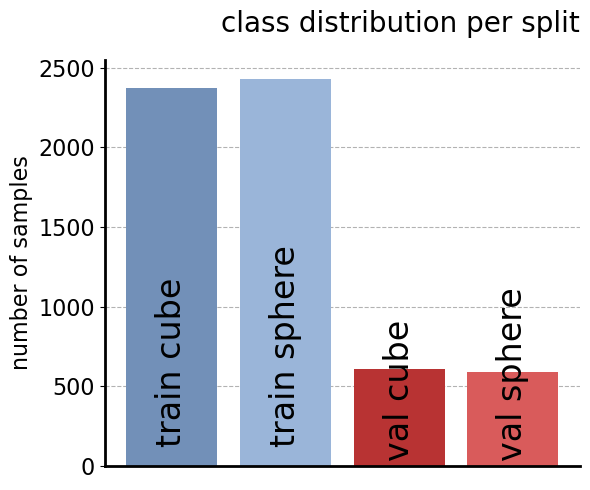

In [5]:
# ===============================
# Dataset Cleanup and Initialization
# ===============================

# Remove existing train/val tags to avoid duplication when re-running
dataset.untag_samples(["train", "val"])

F = fe.ViewField

print("="*50)
print(f"DATASET REPORT: {fiftyone_dataset_name}")
print("="*50)

# ===============================
# Global Dataset Statistics
# ===============================

print(f"Total samples (all slices): {len(dataset)}")
print(f"Total grouped pairs: {len(dataset.select_group_slices('rgb'))}")

# ===============================
# Modality-Specific Statistics
# ===============================

for slice_name in dataset.group_slices:
    view = dataset.select_group_slices(slice_name)
    counts = view.count_values("ground_truth.label")
    
    print(f"\nModality: {slice_name.upper()}")
    print(f" - Count: {len(view)}")
    print(f" - Classes: {counts}")
    
    # Inspect metadata of a representative sample
    sample = view.first()
    try:
        with Image.open(sample.filepath) as img:
            print(f" - Dimensions: {img.size} (Width x Height)")
            print(f" - Data Type: {img.mode}")
    except:
        print(" - Metadata: Unable to read file (check mount)")

# ===============================
# Train / Validation Split (80/20)
# ===============================

dataset.clear() 

# Build unique identifiers at the pair level (label + filename stem)
subset_unique_ids = []
for rgb_s, lidar_s in subset:
    label = rgb_s.ground_truth.label # 'cube' or 'sphere'
    stem = Path(rgb_s.filepath).stem  # '1538'
    subset_unique_ids.append(f"{label}_{stem}")

# Deterministic shuffle and split
set_seed(SEED) 
random.shuffle(subset_unique_ids)

split_idx = int(len(subset_unique_ids) * .8) # 80/20 split
train_ids = subset_unique_ids[:split_idx]
val_ids = subset_unique_ids[split_idx:]

# ===============================
# Tag Samples and Track Distributions
# ===============================

final_samples = []
train_distribution = {"cube": 0, "sphere": 0}
val_distribution = {"cube": 0, "sphere": 0} #all zeros to start the counter 

for rgb_s, lidar_s in subset:
    stem = Path(rgb_s.filepath).stem
    label = rgb_s.ground_truth.label
    uid = f"{label}_{stem}"
        
    # Reset tags to ensure no double-tagging if cell is re-run
    rgb_s.tags = []
    lidar_s.tags = []
    
    # Assign tag and track distribution
    if uid in train_ids:
        tag = "train"
        train_distribution[label] += 1
    else:
        tag = "val"
        val_distribution[label] += 1
    
    rgb_s.tags.append(tag)
    lidar_s.tags.append(tag)
    final_samples.extend([rgb_s, lidar_s])
    
dataset.add_samples(final_samples) # Add the finalized samples back to the cleared dataset

print(f"\n✅ Cleaned and Re-added {len(dataset)} samples.")
print(f"✅ Group slices: {dataset.group_slices}")

# ===============================
# Split Integrity Check & Persistence
# ===============================

intersect = set(train_ids).intersection(set(val_ids))
if len(intersect) > 0:
    raise ValueError(f"Overlapping IDs between train and val splits: {intersect}")
else:
    # Save as a dictionary
    split_data = {
        "train": train_ids,
        "val": val_ids,
        "seed": SEED,
        "subset_percentage": PERCENTAGE_SUBSET,
    }

    mapping_file = "subset_splits.json"
    with open(f"{ROOT_PATH}/{mapping_file}", "w") as f:
        json.dump(split_data, f, indent=4)

    print(f"✅ Saved split to {mapping_file}")
    print(f"   - Train samples: {len(train_ids)}")
    print(f"   - Val samples: {len(val_ids)}")

    print(f"\nSplit sizes (on pairs):")
    print(f" - Train: {len(train_ids)}")
    print(f" - Validation: {len(val_ids)}")
    
# ===============================
# Dataset Schema Summary
# ===============================

print(f"\nSample fields:")
for field_name, field in dataset.get_field_schema().items():
    print(f"  - {field_name}: {field}")
print("="*60)

# ===============================
# Plot Label Prior per Split
# ===============================

labels = ['train cube', 'train sphere', 'val cube', 'val sphere']
counts = [train_distribution['cube'], train_distribution['sphere'], 
          val_distribution['cube'], val_distribution['sphere']]

plot_class_distribution(labels, counts, f"{RESULTS_DIR}/task1_label_split_distribution.png")

### Requirement 2.3 (Visual Exploration)

In this step, we launch the FiftyOne application to interactively inspect our constructed dataset. The app allows visual exploration of both RGB and LiDAR modalities side-by-side through the grouped view.

After running this cell, follow the instructions printed below to access the app:

1. If the inline app view is blank, check the 'PORTS' tab in VS Code.  
2. Ensure port `5151` is forwarded to `127.0.0.1:5151`.  
3. Open the link provided in your local browser ([http://127.0.0.1:5151](http://127.0.0.1:5151)).  
4. In the app, click the “Slice” icon at the top right to select either the RGB or LiDAR view.
5. Click on a sample to view the corresponding RGB and LiDAR data side-by-side in the top-left panel.

In [6]:
session = fo.launch_app(dataset)

From the interactive inspection via the FiftyOne app, we identified several characteristics of the constructed dataset:
1. **Modality Dominance (LiDAR Volume vs. RGB Surface):** Monocular RGB images only provide a limited 2D projection and often only show one or two faces of an object. In contrast, LiDAR depth data captures a more complete volumetric signature. LiDAR points often 'wrap' around edges, which provides a clearer distinction between curved surfaces (spheres) and planar transitions (cubes), which may appear ambiguous in RGB due to perspective or lighting.
2. **Color as a Potential Semantic Distractor:** RGB introduces color features which, for a purely geometric classification task, may act as distractors rather than discriminative cues. If the synthetic generator contains subtle biases, the model could erroneously associate colors with specific classes, whereas LiDAR ensures learning is based solely on geometric structure.
3. **High Background Prominence:** Both modalities contain a substantial proportion of background (black pixels or null depth). This ratio enables the model to rapidly converge by enabling it to quickly isolate the foreground object before learning discriminative features.

From these observations, we abstract several dataset patterns:
1. **Synthetic Redundancy & Overfitting Risk:** The dataset primarily consists of repeated primitive objects with limited variation in scale or orientation. While this leads to near-perfect accuracy in both single and multi-modal models, it also implies a risk of overfitting. Future dataset iterations should include noise, occlusions, or overlapping objects to improve robustness.
2. **Strong Feature Correlation Across Modalities:**  Spatial correlations between RGB and LiDAR are high, with RGB edge transitions aligning closely with LiDAR depth discontinuities. This redundancy explains why intermediate embeddings concatenations, can outperform "late" ones: the model would benefit from early cross-modal feature alignment.
3. **Balanced Class Distribution:** The dataset maintains an approximate 50/50 split between cubes and spheres, ensuring that the observed high accuracy is not affected by class imbalance.

For an effective visualization of these characteristics and patterns, please refer to the screenshots saved in `results/fiftyone_figures_screenshots`.

#### Sanity Check for Dataset Files and Metadata

If the FiftyOne app visualization does not work, run the following cell to ensure that the first sample in the dataset exists and that all required metadata has been computed.

In [7]:
# Sanity check: verify first sample and compute metadata
sample = dataset.first()
assert os.path.exists(sample.filepath), "File not found! Check the dataset path."

dataset.compute_metadata()

Computing metadata...
 100% |█████████████| 11998/11998 [15.1s elapsed, 0s remaining, 1.0K samples/s]     
